In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

INPUT_DIR = './input'
#INPUT_DIR = '/kaggle/input'
TRAIN_PATH = INPUT_DIR + '/train.csv'
TEST_PATH = INPUT_DIR + '/test.csv'
SUBMISSION_PATH = INPUT_DIR + '/sample_submission.csv'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Data Pre-Processing

In [8]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import Normalizer, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

def createAvgStd(df):
    '''
    Create new features: avg and std
    '''

    df['avg'] = 0
    for i in range(3, 17):
        df['avg'] += df['measurement_'+str(i)].copy()

    df['avg'] /= 14

    df['std'] = 0
    for i in range(3, 17):
        df['std'] += (df['measurement_'+str(i)].copy() - df['avg'].copy()) ** 2
        df = df.drop(['measurement_'+str(i)].copy(), axis=1)

    df['std'] /= 14 
    df['std'] = np.sqrt(df['std'].copy())

    return df

def dfToNumpy(csv_file):
    '''
    Drop some unnecessary features and create avg and std
    Rearrange the order of feature for standardization in the following training
    '''

    df = pd.read_csv(csv_file)
    num_of_rows = len(df['id'])

    df = df.drop(['id', 'product_code', 'attribute_0', 'attribute_1', 'attribute_2', 'attribute_3'], axis=1)   
    
    loading = df['loading'].copy()
    

    for i in range(0, 17):
        df['measurement_'+str(i)] = df['measurement_'+str(i)].copy() / loading.copy()

    df = createAvgStd(df)
    #print("New dataframe columns: {col}, number of columns = {num}".format(col=df.columns.to_list(), num=len(df.columns.to_list())))


    measurement = ['measurement_17', 'measurement_0', 'measurement_1', 'measurement_2']
    no_std = ['std', 'avg']
    need_std = ['loading']
    #need_std = []
    failure = ['failure']

    if 'failure' in df.columns.to_list():
        columns = failure + no_std + need_std + measurement
    else:
        columns = no_std + need_std + measurement

    #print("Data Frame has columns: ", columns)
    df = df[columns]

    #print(df)
    #print("Data Frame has columns: ", df.columns.to_list())

    features = df.to_numpy()
    
    return features, df.columns
            

def getLabel(csv_file):
    df = pd.read_csv(csv_file)
    label = df['failure'].to_numpy()
    print("label shape is: ", label.shape)

    return label

def handleMissingValue(features):

    '''
    Use KNN Imputer to fill in NaN
    '''
    imputer = KNNImputer(n_neighbors=5)
    imputer.fit(features)
    new_features = imputer.fit_transform(features)

    return imputer, new_features

def Standardize(features):
    scaler = StandardScaler()
    scaler.fit(features)

    new_features = scaler.transform(features)

    return scaler, new_features

def checkCorr(df):
    '''
    To plot the graph of correlation
    '''
    plt.figure(figsize=(20, 15))

    sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)


In [9]:
features, columns = dfToNumpy(TRAIN_PATH)
labels = getLabel(TRAIN_PATH)
imputer, features = handleMissingValue(features)

attributes = features[:, 0:3]
scaler, std_features = Standardize(features[:, 3:])

features = np.concatenate((attributes, std_features), axis=1)

label shape is:  (26570,)


Data has feature:  ['std', 'avg', 'loading', 'measurement_17', 'measurement_0', 'measurement_1', 'measurement_2']


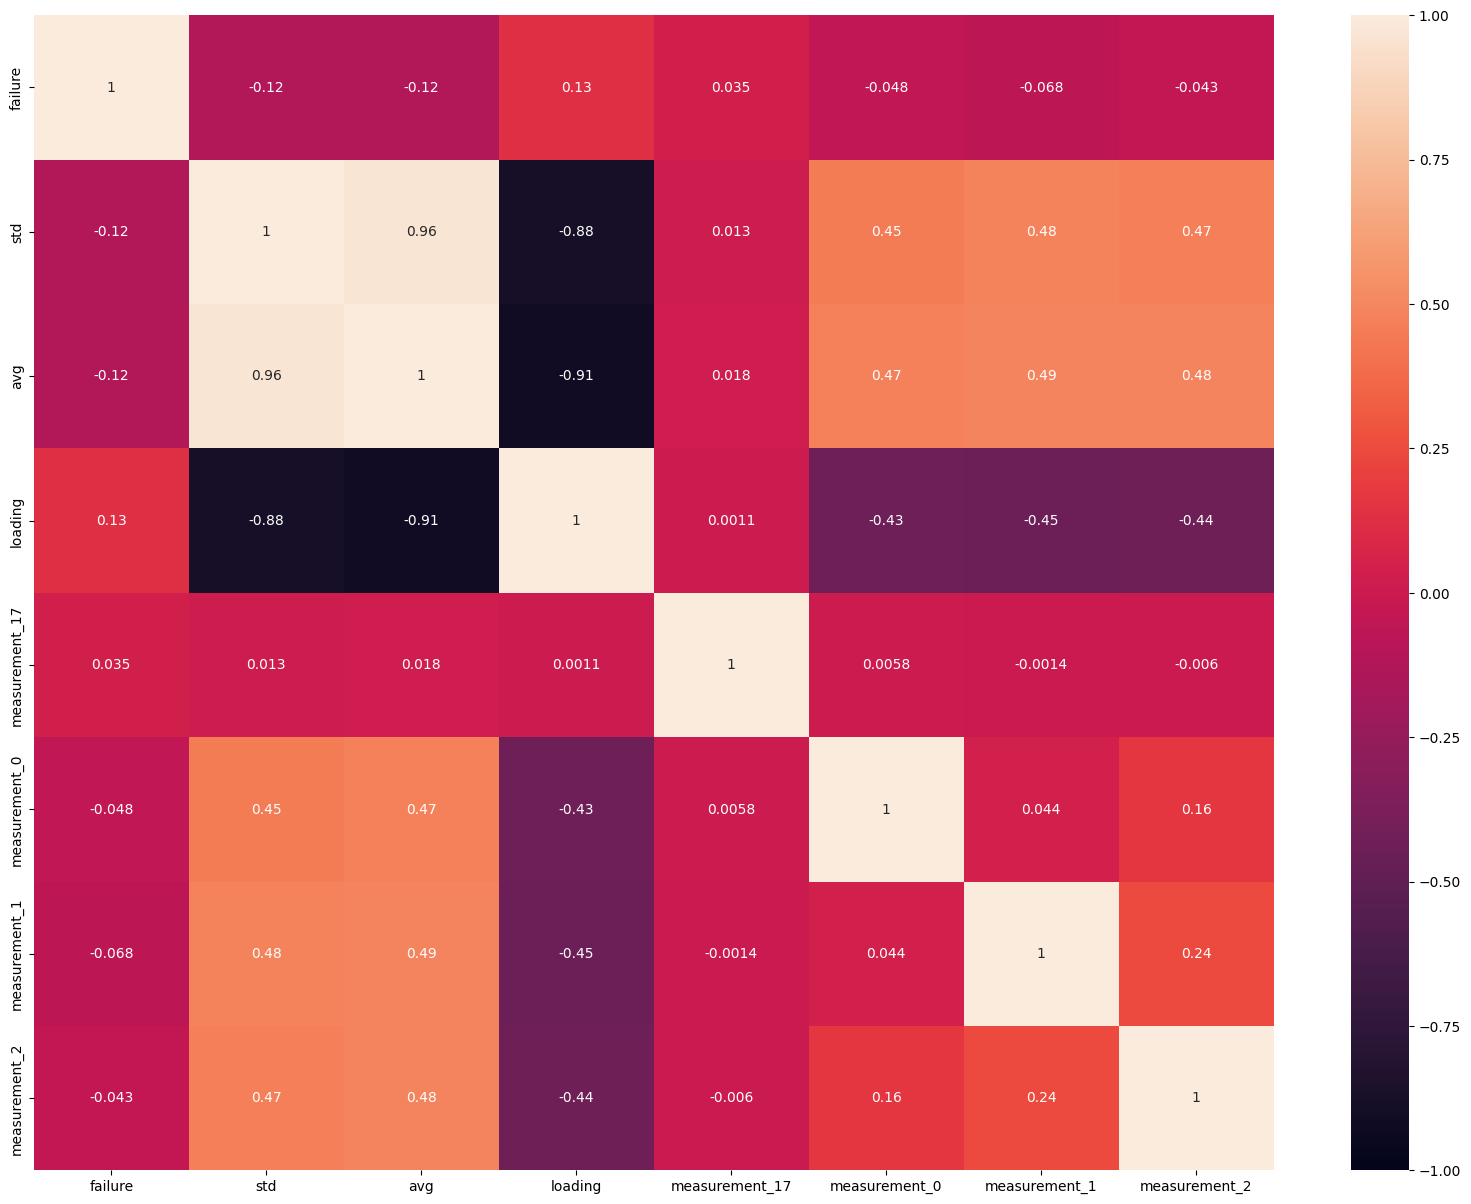

In [10]:

df = pd.DataFrame(features, columns=list(columns))
df_copy = df.copy()
checkCorr(df_copy)

df = df.drop(['failure'], axis=1)
print("Data has feature: ", df.columns.to_list())
train_features = df.to_numpy()

### Model: Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(train_features, labels)

LogisticRegression()

### Save parameters and model

In [12]:
import pickle

model_name = 'model.pkl'
imputer_name = 'imputer.pkl'
scaler_name = 'scaler.pkl'

model_file = open(model_name, 'wb')
imputer_file = open(imputer_name, 'wb')
scaler_file = open(scaler_name, 'wb')


pickle.dump(clf, model_file)
pickle.dump(imputer, open(imputer_name, 'wb'))
pickle.dump(scaler, open(scaler_name, 'wb'))

model_file.close()
imputer_file.close()
scaler_file.close()

print("Done saving")

Done saving
